### Домашнее задание ###
<ol>
<li>скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
<li>там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
<li>сделать разбиение набора данных не тренировочную и тестовую выборки
<li>сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
<li>провести uplift-моделирование 3 способами: 
    <ul>
        <li>одна модель с признаком коммуникации (S learner)
        <li>модель с трансформацией таргета (трансформация классов п. 2. 1)
        <li>вариант с двумя независимыми моделями
    </ul>
<li>в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
<li>построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
<li>(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
    <ul>
    <li>сделать прогноз и получить uplift для тестовой выборки 
    <li>отсортировать тестовую выборку по uplift по убыванию
    <li>разбить на децили (pandas qcut вам в помощь)
    <li>для каждого дециля посчитать среднюю conversion
    </ul>
<li>(опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерев
</ol>

1. Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./data.csv')
data.head(5)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
data.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
data.head(3)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0

In [4]:
if data["treatment"].dtype != np.int64:
    data["treatment"] = data["treatment"].map(lambda x: int(x != "No Offer"))
data["treatment"].head(3)

0    1
1    0
2    1
Name: treatment, dtype: int64

In [5]:
features = data.drop(columns=["target"])
target = data["target"]

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.33, 
    random_state=42
)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Категориальные признаки заменим на dummy переменные

In [7]:
X_train = pd.get_dummies(X_train, prefix=['zip_code', 'channel'])
X_test = pd.get_dummies(X_test, prefix=['zip_code', 'channel'])
X_train.head(5)

recency  history  used_discount  used_bogo  is_referral  treatment  \
44233       10    29.99              1          0            0          1   
58749        9    60.25              0          1            0          0   
56296        8   292.30              1          1            1          1   
23444        8    49.05              1          0            0          1   
48936       12   324.32              1          0            0          1   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
44233               0                   0               1   
58749               0                   0               1   
56296               0                   0               1   
23444               0                   0               1   
48936               0                   0               1   

       channel_Multichannel  channel_Phone  channel_Web  
44233                     0              0            1  
58749                     0              1            0  
56296                     0              0            1  
23444                     0              1            0  
48936                     0              0            1

In [8]:
data['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

Явно дисбаланс классов, будем выравнивать

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

y_resampled.value_counts(), y_test_resampled.value_counts()

(0    36570
 1    36570
 Name: target, dtype: int64,
 0    18036
 1    18036
 Name: target, dtype: int64)

In [10]:
X_train = X_resampled
y_train = y_resampled
X_test = X_resampled
y_test = y_resampled

5. провести uplift-моделирование 3 способами: 
    <ul>
        <li>одна модель с признаком коммуникации (S learner)
        <li>модель с трансформацией таргета (трансформация классов п. 2. 1)
        <li>вариант с двумя независимыми моделями
    </ul>

#### одна модель с признаком коммуникации (S learner) ####

In [11]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [12]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(
    X_train.drop(columns=['treatment']), 
    y_train, 
    X_train['treatment']
)

In [13]:
uplift_sm = sm.predict(X_test.drop(columns=['treatment']))
sm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
sm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.2)
sm_score_at_10, sm_score_at_20

(0.3062395674099855, 0.27582567884124154)

In [14]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_at_10)
models_results['uplift@20%'].append(sm_score_at_20)

**модель с трансформацией таргета (трансформация классов п. 2. 1)**

In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train.drop(columns=['treatment']), y_train, X_train['treatment'])

uplift_ct = ct.predict(X_test.drop(columns=['treatment']))

ct_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.1)
ct_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.2)
ct_score_at_10, ct_score_at_20

(0.35052772550344063, 0.29554260632730506)

In [16]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_at_10)
models_results['uplift@20%'].append(ct_score_at_20)

**вариант с двумя независимыми моделями**

In [17]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train.drop(columns=['treatment']), y_train, X_train['treatment']
)

uplift_tm = tm.predict(X_test)

tm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
tm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

tm_score_at_10, tm_score_at_20

(0.4621234130117984, 0.3895547962174476)

In [18]:
models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_at_10)
models_results['uplift@20%'].append(tm_score_at_20)

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [19]:
pd.DataFrame(models_results)

approach  uplift@10%  uplift@20%
0            SoloModel    0.306240    0.275826
1  ClassTransformation    0.350528    0.295543
2            TwoModels    0.462123    0.389555

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [20]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=X_train['treatment'].map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

features = X_train.columns

Wall time: 10.7 s


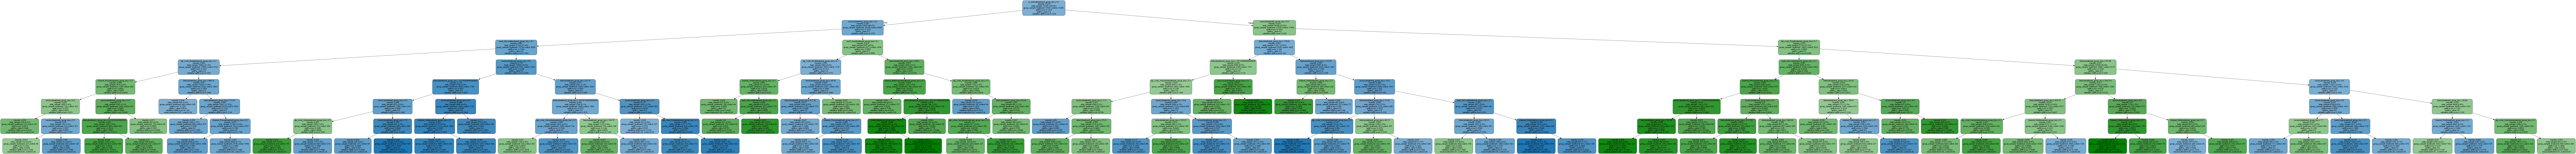

In [21]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [22]:
graph.write_png("tree.png")

True

На рисунке видим дерево глубиной 8. 

**(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:** 
    <ul>
    <li>сделать прогноз и получить uplift для тестовой выборки 
    <li>отсортировать тестовую выборку по uplift по убыванию
    <li>разбить на децили (pandas qcut вам в помощь)
    <li>для каждого дециля посчитать среднюю conversion
    </ul>

In [32]:
from sklift.metrics import uplift_by_percentile

In [44]:
uplift_by_percentile( y_train.values, uplift_ct , X_train['treatment'].values, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_treatment  n_control  response_rate_treatment  \
percentile                                                    
0-10               5723       1591                 0.728464   
10-20              5564       1750                 0.664809   
20-30              5239       2075                 0.628364   
30-40              5208       2106                 0.587558   
40-50              5196       2118                 0.560624   
50-60              5222       2092                 0.521639   
60-70              5093       2221                 0.493226   
70-80              5002       2312                 0.448820   
80-90              4802       2512                 0.392128   
90-100             4592       2722                 0.273737   
total             51641      21499                 0.537441   

            response_rate_control    uplift  std_treatment  std_control  \
percentile                                                                
0-10                     0.377121  0.351343       0.005879     0.012151   
10-20                    0.386857  0.277952       0.006329     0.011642   
20-30                    0.458313  0.170051       0.006676     0.010938   
30-40                    0.432099  0.155459       0.006821     0.010794   
40-50                    0.404627  0.155997       0.006885     0.010665   
50-60                    0.434990  0.086649       0.006913     0.010839   
60-70                    0.417830  0.075396       0.007006     0.010465   
70-80                    0.402249  0.046571       0.007033     0.010198   
80-90                    0.380573  0.011555       0.007045     0.009687   
90-100                   0.403012 -0.129276       0.006580     0.009402   
total                    0.410066  0.127376       0.067167     0.106782   

            std_uplift  
percentile              
0-10          0.013498  
10-20         0.013251  
20-30         0.012815  
30-40         0.012769  
40-50         0.012694  
50-60         0.012856  
60-70         0.012594  
70-80         0.012388  
80-90         0.011978  
90-100        0.011475  
total         0.126318

In [45]:
from sklift.viz import plot_uplift_by_percentile

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


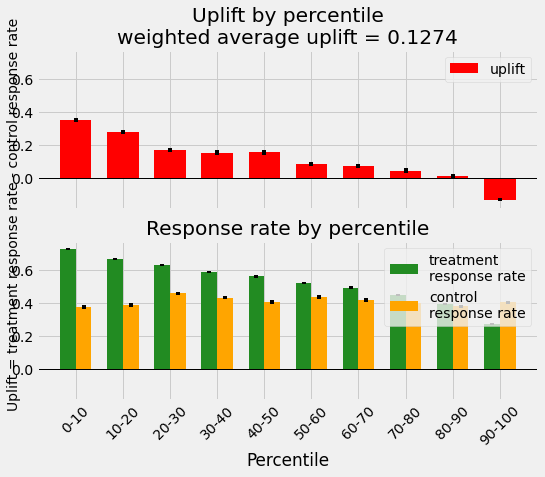

In [46]:
plot_uplift_by_percentile(y_train.values, uplift_ct , X_train['treatment'].values, 
                          strategy='overall', kind='bar');